# 《实用金融数据科学》
# 如何分析消费者对金融产品的投诉以及公司的应对（公司/分行层面）

<img src = './ref/US Consumer Finance Complaints.jpg'>

# US Consumer Finance Complaints
### US consumer complaints on financial products and company responses

原始数据和背景介绍：

Original link and decription at https://www.kaggle.com/cfpb/us-consumer-finance-complaints


In [4]:
# KudosData.com - Python 2 compatibility
# Force matplotlib to not use any Xwindows backend:

# import matplotlib
# matplotlib.use('Agg')

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [5]:
from datetime import timedelta
import seaborn as sns

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jieba
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
from sklearn.metrics import confusion_matrix, roc_curve, auc

from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']  
mpl.rcParams['axes.unicode_minus'] = False 
mpl.rcParams['font.size'] = 14

np.random.seed(88)

# Exploratory Data Analysis (EDA) 探索性数据分析

https://www.kaggle.com/mikevdickson/d/cfpb/us-consumer-finance-complaints/exploring-the-dataset

https://www.kaggle.com/honestsoul/d/cfpb/us-consumer-finance-complaints/analyzing-consumer-complaints


In [7]:
import numpy as np # linear algebra （线性代数）
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) （数据处理，csv格式文件的输入/输出）
# import matplotlib.pyplot as plt


In [8]:
# source = pd.read_csv('../input/consumer_complaints.csv')
source = pd.read_csv('./consumer_complaints.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print(source.shape)
source.head() #数据预览
#在拿到数据，通过数据预览可以对你的数据有一个大概的了解，通过预览我们可以知道：
   # 一共有555957行，18列
    #每一列的标题名称，每一列大致的内容

(555957, 18)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [12]:
# data pre-processing（数据预处理）
data = source.copy()
#Type casting（数据转换）
data.rename(columns = {'consumer_disputed?':'consumer_disputed'},inplace = True)
data['date_received'] = pd.to_datetime(data['date_received'], format='%m/%d/%Y')
data['date_sent_to_company'] = pd.to_datetime(data['date_sent_to_company'], format='%m/%d/%Y')

#Check size and dtypes（检查数据的大小和数据类型）
# print(data.shape)
# print('')
# print(data.dtypes)

In [13]:
#CLEANING THE DATA （数据清理）
'''
Correct dates where the submitted date is less than the received date by making submitted date = received date
（
    submitted date：公司回复投诉的日期
    received date：客户提出投诉的日期
    如果公司回复投诉的日期早于客户提出投诉的日期，则将公司回复投诉的日期改为客户提出投诉的日期
    ）
'''

data['processing_time'] = data['date_sent_to_company']-data['date_received']
data.loc[data['processing_time']<timedelta(days=0),'date_sent_to_company'] = data['date_received']
data.drop('processing_time',axis=1, inplace=True)

In [14]:
#Features
#生成一些新的列
data['month_received'] = data['date_received'].dt.month
data['year_received'] = data['date_received'].dt.year
data['month_sent_to_company'] = data['date_sent_to_company'].dt.month
data['year_sent_to_company'] = data['date_sent_to_company'].dt.year
data['processing_time'] = data['date_sent_to_company']-data['date_received']


A = [d.date() for d in data['date_received']]
B = [d.date() for d in data['date_sent_to_company']]
data['processing_time'] = np.busday_count(A, B)


In [15]:
#More Features
#生成更多地列
grp = data.groupby('year_received')
days_factor = 365.25/(grp['date_received'].max()-grp['date_received'].min() + timedelta(days=1)).dt.days.astype('int')
days_factor.name = 'days_factor'
cleaned = data.join(days_factor,on='year_received',how='left')
cleaned.head()


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,...,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,month_received,year_received,month_sent_to_company,year_sent_to_company,processing_time,days_factor
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,...,Closed with explanation,Yes,Yes,511074,8,2013,9,2013,2,1.000685
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,...,Closed with explanation,Yes,Yes,511080,8,2013,9,2013,2,1.000685
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,...,Closed with explanation,Yes,No,510473,8,2013,9,2013,13,1.000685
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,...,Closed with explanation,Yes,Yes,510326,8,2013,8,2013,0,1.000685
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,...,Closed with explanation,Yes,Yes,511067,8,2013,8,2013,0,1.000685


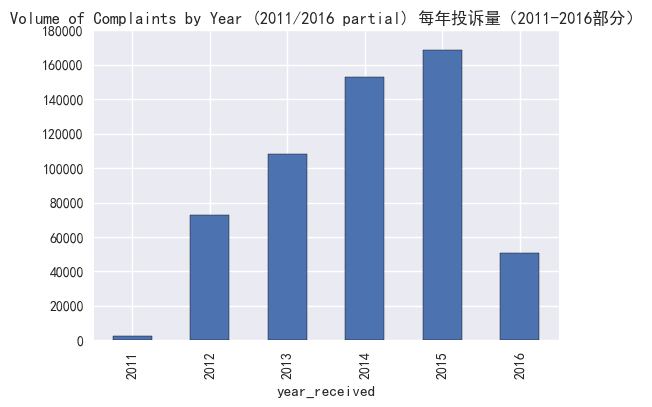

In [20]:
data = cleaned.copy()
grp = data.groupby('year_received')
grp.size().plot(kind='bar',title='Volume of Complaints by Year (2011/2016 partial) 每年投诉量（2011-2016部分）')


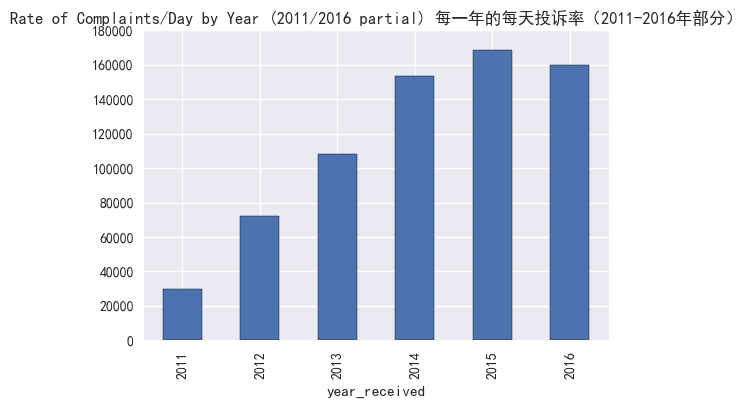

In [19]:
grp = data.groupby('year_received')
complaint_rate = grp.size().mul(grp['days_factor'].min())
complaint_rate.plot(kind='bar',title='Rate of Complaints/Day by Year (2011/2016 partial) 每一年的每天投诉率（2011-2016年部分）')


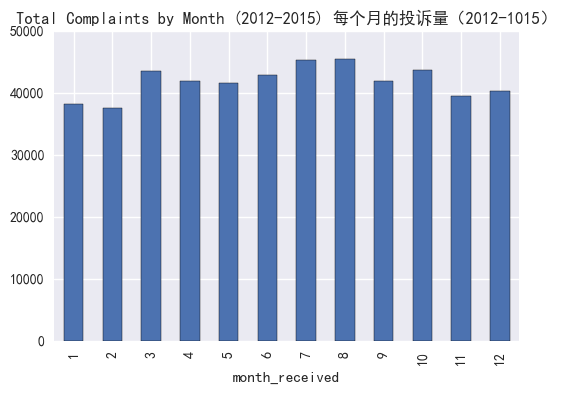

In [18]:
mask = (data['year_received']>2011) & (data['year_received']<2016)
grp = data[mask].groupby('month_received')
grp.size().plot(kind='bar',title='Total Complaints by Month (2012-2015) 每个月的投诉量（2012-1015）')


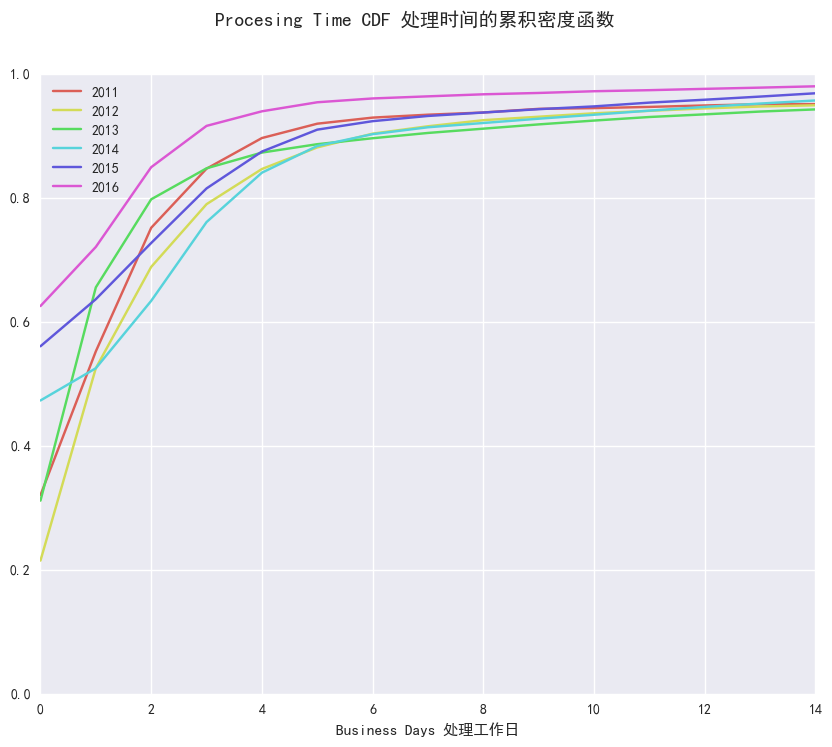

In [21]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
years = np.arange(2011,2017,1)
color = sns.color_palette("hls", 6)
for y in years:
    processing_time_counts = data[data['year_received']==y]['processing_time'].value_counts().sort_index()
    total = sum(processing_time_counts)
    processing_time_counts_CDF = processing_time_counts.cumsum()/total
    ax.plot(processing_time_counts_CDF.index.values.astype('timedelta64[D]'),processing_time_counts_CDF.values,label=y,color=color[y-2011])
    #ax = processing_time_counts_CDF.plot(kind='line',title='Processing Time CDF',xlim=(0,14),ylim=(0,1))


ax.axis([0,14,0,1])
ax.legend(loc='best')
ax.set_xlabel('Business Days 处理工作日')
fig.suptitle('Procesing Time CDF 处理时间的累积密度函数')


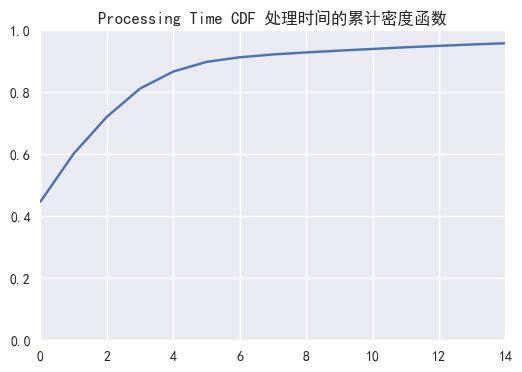

In [22]:
processing_time_counts = data['processing_time'].value_counts().sort_index()
total = sum(processing_time_counts)
processing_time_counts_CDF = processing_time_counts.cumsum()/total
ax = processing_time_counts_CDF.plot(kind='line',title='Processing Time CDF 处理时间的累计密度函数',xlim=(0,14),ylim=(0,1))


# Let's look at complaints against Company and Product:
# 让我们来看看公司与产品这两方面的投诉情况

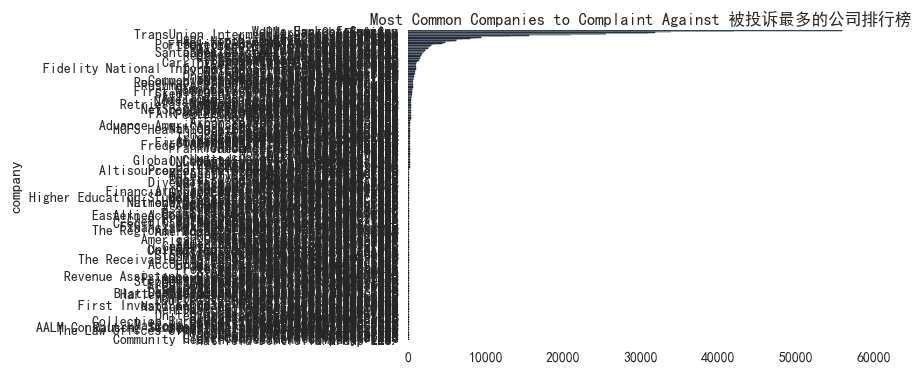

In [23]:
grp = data.groupby('company')
grp = grp.size().sort_values(ascending=False)
#top10 = grp[10::-1]
top10 = (grp[:500])[::-1]
top10.plot(kind='barh',title='Most Common Companies to Complaint Against 被投诉最多的公司排行榜')


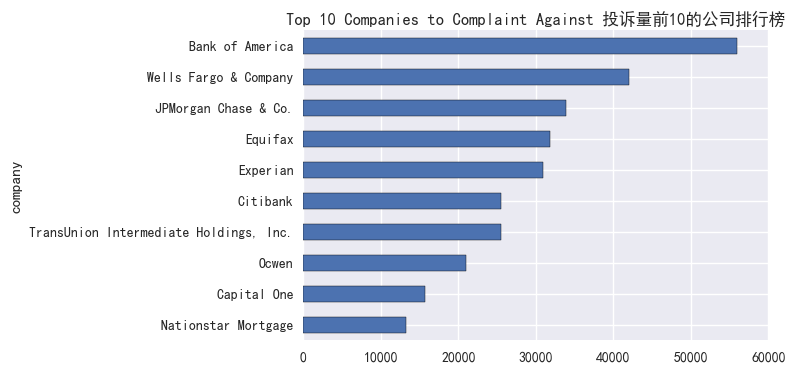

In [24]:
grp = data.groupby('company')
grp = grp.size().sort_values(ascending=False)
#top10 = grp[10::-1]
top10 = (grp[:10])[::-1]
top10.plot(kind='barh',title='Top 10 Companies to Complaint Against 投诉量前10的公司排行榜')


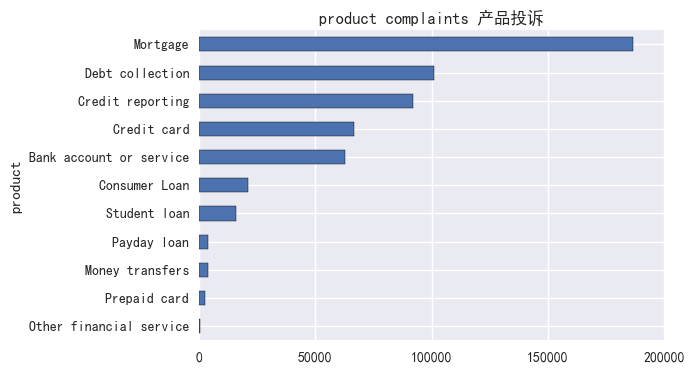

In [25]:
data['product'].unique()
data.groupby('product').size().sort_values().plot(kind='barh',title='product complaints 产品投诉')


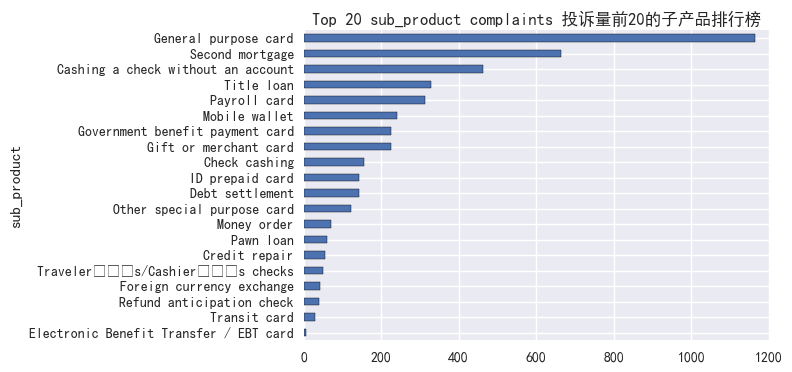

In [26]:
# data['sub_product'].unique()
data.groupby('sub_product').size().sort_values()[0:20].plot(kind='barh',title='Top 20 sub_product complaints 投诉量前20的子产品排行榜')


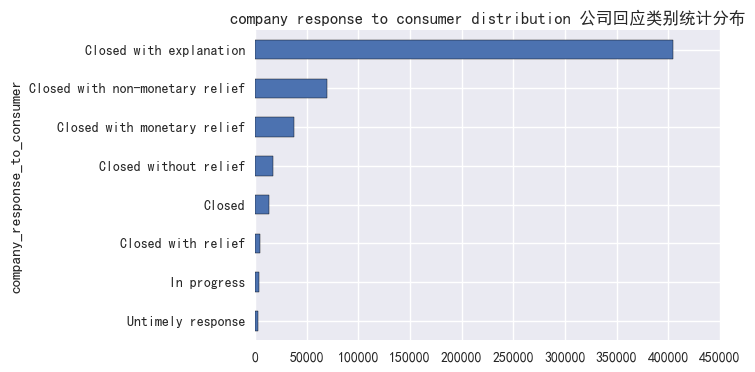

In [27]:
# data['company_response_to_consumer'].unique()
data.groupby('company_response_to_consumer').size().sort_values().plot(kind='barh',title='company response to consumer distribution 公司回应类别统计分布')


In [21]:
grp = data.pivot_table(index='company_response_to_consumer',columns='consumer_disputed',values='date_received',aggfunc='count')
grp

consumer_disputed,No,Yes
company_response_to_consumer,,
Closed,10490,2909
Closed with explanation,313815,90478
Closed with monetary relief,34054,4208
Closed with non-monetary relief,61265,8972
Closed with relief,4591,714
Closed without relief,13058,4851
In progress,3763,NaN
Untimely response,2787,2


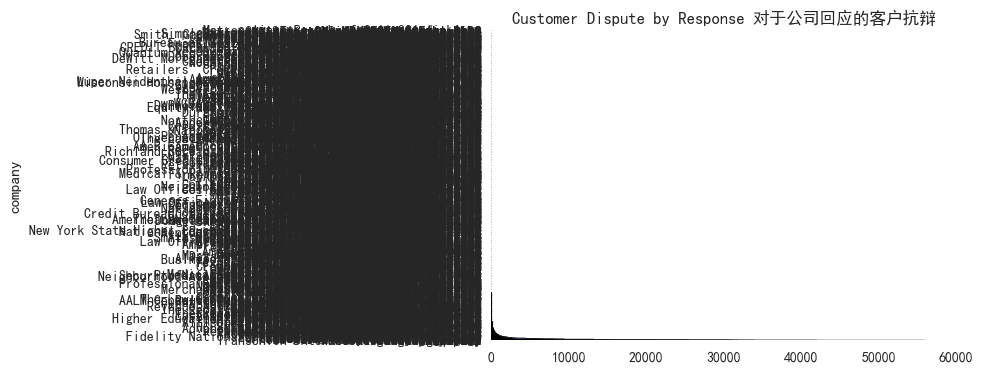

In [29]:
grp.plot(kind='barh',stacked=True, title='Customer Dispute by Response 对于公司回应的客户抗辩')


In [32]:
pct = grp['Yes']/(grp['No']+grp['Yes'])
pct.plot(kind='barh',title='Customer Dispute Rate by Response 对于公司回复的客户抗辩率')


KeyError: 'Yes'

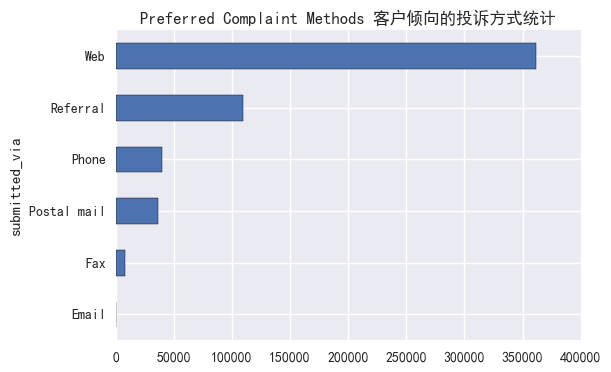

In [33]:
grp = data.groupby('submitted_via')
grp.size().sort_values().plot(kind='barh',title='Preferred Complaint Methods 客户倾向的投诉方式统计')


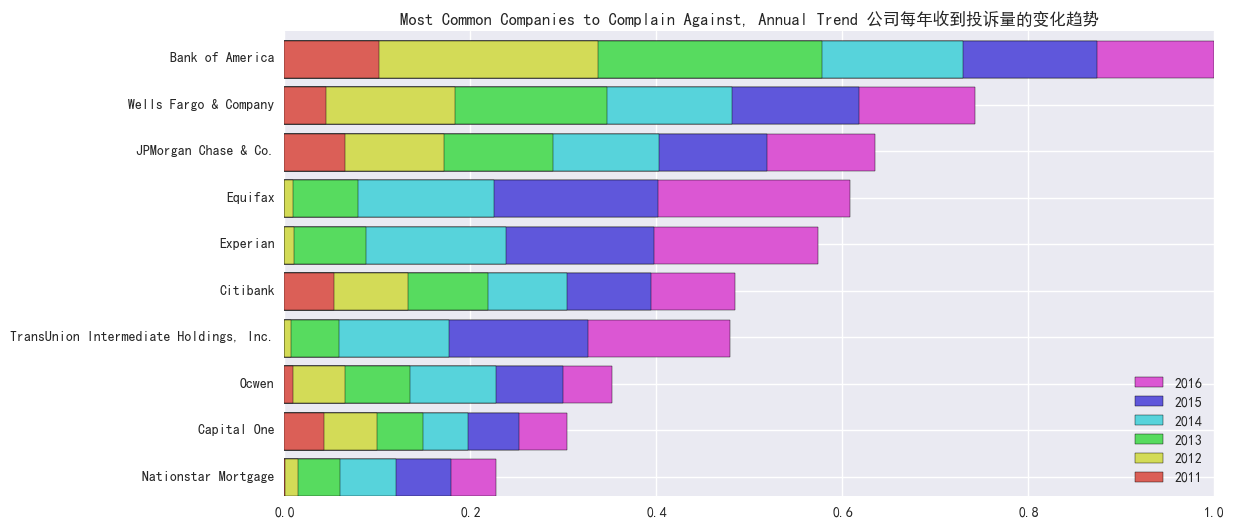

In [35]:
grp = data.groupby(['company','year_received'])
grp = grp.size().mul(grp['days_factor'].min()).unstack().fillna(0)
grp['total'] = grp.sum(axis=1)
grp = grp.sort_values('total',ascending=False)
grp = grp.div(grp['total'].max(), axis=0)
grp = grp.drop('total',axis=1)
top10 = (grp[:10])[::-1]
ind = np.arange(10)
series1 = top10.loc[:,2011].values
cumulative = top10.cumsum(axis=1)
color = sns.color_palette("hls", 6)
plt.figure(figsize=(12,6))
for i in np.arange(5,-1,-1):
    plt.barh(ind, cumulative.iloc[:,i], color=color[i], label=2011+i)
    
plt.yticks(ind + .85/2., top10.index)
plt.title('Most Common Companies to Complain Against, Annual Trend 公司每年收到投诉量的变化趋势')
plt.legend(loc='best')


# Company Comparisons in Terms of Customer Satisfaction
# 基于客户满意度的公司比较

this is just showing number of complained resolved where customers have not disputed.We need to do more to find the best and worst companies when it comes to customer services.


In [26]:
complain_flag = '1'*len(data['state'])
data['complains'] = [ int(x) for x in complain_flag if not x  == ',']

In [27]:
data['percent_resolution'] = np.where((data.timely_response.str.contains('Yes') & data.consumer_disputed.str.contains('No')), 1, 0)
data_best_cc = data.groupby('company').aggregate(np.sum)
data_best_cc.drop('complaint_id', axis = 1, inplace =  True)
data_best_cc['percent_resolution'] = data_best_cc['percent_resolution']/data_best_cc['complains']
data_best_cc['percent_resolution']  = data_best_cc['percent_resolution'] .apply(lambda x : float(x*100))

In [28]:
data_best_cc= data_best_cc[data_best_cc['complains'] >= 5000].sort_values('percent_resolution', ascending = False)
data_best_cc[['percent_resolution', 'complains']]

,percent_resolution,complains
company,,
Experian,87.390390,30905
"TransUnion Intermediate Holdings, Inc.",85.023890,25534
Synchrony Financial,85.013249,9435
"Navient Solutions, Inc.",81.116523,8007
Capital One,80.918864,15628
Encore Capital Group,80.805838,6304
PNC Bank N.A.,79.997132,6974
Equifax,79.115873,31828
Citibank,78.312451,25540


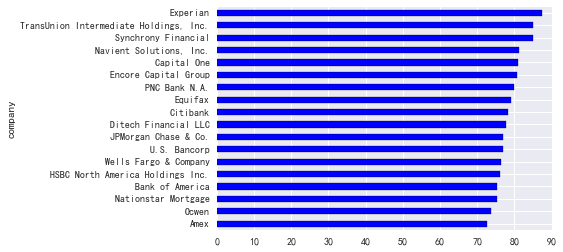

In [29]:
data_best_cc['percent_resolution'].sort_values().plot(kind = 'barh')
# data_best_cc['percent_resolution'].plot(kind = 'barh')

# What's the insight? Experian is the company when it comes to customer satisfaction.

# Basic Language Analysis of Customer Complaint

https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints/comments

In [30]:
# Read in data from pandas
# import pandas as pd

# This is used for fast string concatination
from io import StringIO, BytesIO

# Use nltk for valid words
import nltk
# Need to make hash 'dictionaries' from nltk for fast processing
import collections as co


import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
# import seaborn as sns
# import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

# Read the input
# d = pd.read_csv("./consumer_complaints.csv") # the consumer dataset is now a Pandas DataFrame
d = data # the consumer dataset is now a Pandas DataFrame

# Only interested in data with consumer complaints
d=d[d['consumer_complaint_narrative'].notnull()]

In [31]:
print ('Out of %d complaints, there are %d complaints with detailed customer narratives.' % (len(data), len(d)))

Out of 555957 complaints, there are 66806 complaints with detailed customer narratives.


In [32]:
print(shape(d))
d.head()

(66806, 26)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,...,consumer_disputed,complaint_id,month_received,year_received,month_sent_to_company,year_sent_to_company,processing_time,days_factor,complains,percent_resolution
190126,2015-03-19,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,...,No,1290516,3,2015,3,2015,0,1.000685,1,1
190135,2015-03-19,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,...,No,1290492,3,2015,3,2015,0,1.000685,1,1
190155,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,...,Yes,1290524,3,2015,3,2015,0,1.000685,1,0
190207,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,...,Yes,1290253,3,2015,3,2015,0,1.000685,1,0
190208,2015-03-19,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,...,Yes,1292137,3,2015,3,2015,0,1.000685,1,0


In [33]:
# We want a very fast way to concat strings.
#  Try += if you don't believe this method is faster.


# Python3
s=StringIO()
# Python2
# s=BytesIO()

d['consumer_complaint_narrative'].apply(lambda x: s.write(x))

k=s.getvalue()
s.close()
k=k.lower()
k=k.split()

In [34]:
# nltk.download()

In [35]:
# Next only want valid strings
words = co.Counter(nltk.corpus.words.words())
stopWords =co.Counter( nltk.corpus.stopwords.words() )
k=[i for i in k if i in words and i not in stopWords]
s=" ".join(k)
c = co.Counter(k)

### At this point we have k,s and c

k Array of words, with stop words removed

s Concatinated string of all comments

c Collection of words

In [36]:
# Take a look at the 14 most common words
c.most_common(15)

[('credit', 82342),
 ('account', 58454),
 ('would', 47840),
 ('loan', 39920),
 ('bank', 37751),
 ('told', 36548),
 ('payment', 36509),
 ('received', 30722),
 ('debt', 27829),
 ('mortgage', 27401),
 ('never', 25973),
 ('information', 25223),
 ('pay', 24479),
 ('get', 24163),
 ('company', 23792)]

In [37]:
print(s[0:100])
print('')
print('Length of s: %s' % len(s))

owe despite proof payment sent check invoice continue insist owe collection stop harassment bill alr

Length of s: 26048491


In [38]:
print(k[0:10])
print('')
print('Length of k: %s' % len(k))

['owe', 'despite', 'proof', 'payment', 'sent', 'check', 'invoice', 'continue', 'insist', 'owe']

Length of k: 3707242


In [39]:
print('Length of c: %s' % len(c)) # No. of unique words !

Length of c: 13962


### Word Cloud

At this point we have some data, so it might be a good idea to take a look at it.

In [41]:
from wordcloud import WordCloud

# Read the whole text.
text = s

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# import matplotlib.pyplot as plt


# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(k),max_font_size=40, relative_scaling=.8).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('World Cloud 词云')
# plt.legend(loc='best')
plt.show()

ImportError: No module named 'wordcloud'

### Taking a look at their stories

These stories claim to involve identity theft and or fraud.

In [42]:
# Let's get some text involving identity theft
searchS='victim of identity theft'


# Python3
vi = d[d['consumer_complaint_narrative'].str.find(searchS) >= 0]

# Python2
# vi = d[d['consumer_complaint_narrative'].str.find(searchS.encode('utf8')) >= 0]


print('\nNo. <identity theft complaints> consumer narratives: %d\n' % len(vi.index))

d['ID Victim']=None
d['Complts']=1
d['Money Relief']=None  # This will be for 'Closed with monetary relief'


# Python3
d['ID Victim'] = d[d['consumer_complaint_narrative'].str.find(searchS) >= 0]
# Python2
# d['ID Victim'] = d[d['consumer_complaint_narrative'].str.find(searchS.encode('utf8')) >= 0]

d['Money Relief']=d[d['company_response_to_consumer'] == 'Closed with monetary relief']


# Take a look at some sample stories  mindex to mindex_inc
# Adjust this, to see different stories
mindex=20
mindex_inc=5+mindex
si=StringIO()
vi['consumer_complaint_narrative'].iloc[mindex:mindex_inc].apply(lambda x: si.write(x+'\n___\n\n'))

t=si.getvalue()
si.close()
print(t)


No. <identity theft complaints> consumer narratives: 505

I am a victim of identity theft and I received and alert that a new unknownaccount appeared on my credit. I called Equifax and was told that I could not launch a dispute over the phone and was advised to fax my information over againalong with the police report that is already on file and include the newaccount. To date, both Equifax has not removed the account!!!! 
XXXX XXXX XXXX Account Number XXXX 

___

I was a victim of identity theft and this account needs to be removed asap this account is fraudulent and continued attempts to collect is harrasment please help me in getting this resolved. 

___

I am a victim of identity theft and Equifax refuses to assist me in making sure my credit profile is accurate. I have several records as proof. 

I am trying to repair the damage done to my credit due to identity theft. I have been disputing information for several years and this credit bureau has been extremely uncooperative and 

In [43]:
# We might be missing data on just fraud...
# Search for all cases of theft or fraud
searchS0='victim'
searchS1='identity'
searchS_OR=['theft','fraud']


# Python3
vi2 = d[(d['consumer_complaint_narrative'].str.find(searchS0) >= 0) &
        (d['consumer_complaint_narrative'].str.find(searchS1) >= 0) &
       ((d['consumer_complaint_narrative'].str.find(searchS_OR[0]) >= 0) |
        (d['consumer_complaint_narrative'].str.find(searchS_OR[1]) >= 0))
        ]
# Python2
# vi2 = d[(d['consumer_complaint_narrative'].str.find(searchS0.encode('utf8')) >= 0) &
#         (d['consumer_complaint_narrative'].str.find(searchS1.encode('utf8')) >= 0) &
#        ((d['consumer_complaint_narrative'].str.find(searchS_OR[0].encode('utf8')) >= 0) |
#         (d['consumer_complaint_narrative'].str.find(searchS_OR[1].encode('utf8')) >= 0))
#         ]

In [44]:
# vi2.count()

g=vi2.groupby(['issue'])
gg=g.count().reset_index()
gg.sort_values(by='Complts',inplace=True)
gg=g['Complts','ID Victim','Money Relief'].count().reset_index()
gg.sort_values(by='Complts',inplace=True, ascending=False)

In [49]:
len(gg) # No. unique issues

41

In [50]:
# Taking a look at common complaints
# Need to format this...but note only 9 cases where it
# was "Closed with monetary relief"  m==1

#gg.head(4)
with pd.option_context('display.max_rows', 20, 'display.max_columns', 4):
    print(gg)

                                       issue  Complts  ID Victim  Money Relief
24    Incorrect information on credit report      242        169             0
9      Cont'd attempts collect debt not owed      155        137             1
21     Identity theft / Fraud / Embezzlement       53         41             9
0    Account opening, closing, or management       35         28             1
14  Credit reporting company's investigation       29         18             0
37  Unable to get credit report/credit score       22         18             1
13  Credit monitoring or identity protection       18         14             1
17                  Deposits and withdrawals       13          6             2
23          Improper use of my credit report       11          8             1
18           Disclosure verification of debt       10          8             0
..                                       ...      ...        ...           ...
35              Taking out the loan or lease        

# Advanced Language Analysis of Customer Complaint

https://www.kaggle.com/mmrosenb/d/cfpb/us-consumer-finance-complaints/language-analysis

In [51]:
#imports

# import numpy as np
# import pandas as pd
# import nltk
import collections as co

# Python 3
# from io import StringIO
# Python 2
# from io import BytesIO

# import matplotlib.pyplot as plt
import warnings
from IPython.display import display, HTML, Markdown, display

#constants
# %matplotlib inline
def printmd(string):
    display(Markdown(string))
alphaLev = .5

In [52]:
#load in dataset
# complaintFrame = pd.read_csv("./consumer_complaints.csv")
complaintFrame = data

In [53]:
complaintFrame.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,...,consumer_disputed,complaint_id,month_received,year_received,month_sent_to_company,year_sent_to_company,processing_time,days_factor,complains,percent_resolution
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,...,Yes,511074,8,2013,9,2013,2,1.000685,1,0
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,...,Yes,511080,8,2013,9,2013,2,1.000685,1,0
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,...,No,510473,8,2013,9,2013,13,1.000685,1,1
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,...,Yes,510326,8,2013,8,2013,0,1.000685,1,0
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,...,Yes,511067,8,2013,8,2013,0,1.000685,1,0


# CFPB Consumer Complaints: Language Analysis

In this notebook, I will perform Exploratory Data Analysis (EDA) and language analysis on the text-sensitive data found in the [CFPB Consumer Complaints](https://www.kaggle.com/cfpb/us-consumer-finance-complaints) dataset. You can find my analysis on the non-text-sensitve EDA within [this script](https://www.kaggle.com/mmrosenb/d/cfpb/us-consumer-finance-complaints/eda-on-consumer-complaints). As we saw in some summary statistics within that script, about $432499$ observations do not have text-sensitive data, which makes this section a general down-sizing our sample. That being said, this section potentially carries the most important aspects of the consumer complaint.

We will start by pre-processing our text data. Some of the code below is adapted from [Mike Chirico's EDA](https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints).

In [54]:
#consider only narrative observations
complaintNarrativeFrame = complaintFrame[complaintFrame["consumer_complaint_narrative"].notnull()]
complaintNarrativeFrame.reset_index
# build a fast way to get strings
# adapted from 
# https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints

# Python 3
s = StringIO()
# Python 2
# s = BytesIO()

complaintNarrativeFrame["consumer_complaint_narrative"].apply(lambda x: s.write(x))
k=s.getvalue()
s.close()
# memory constraint:
k=k.lower()
k=k.split()

In [55]:
complaintNarrativeFrame = complaintNarrativeFrame.reset_index()
# complaintNarrativeFrame.head()

In [56]:
# Next only want valid strings
words = co.Counter(nltk.corpus.words.words())
stopWords =co.Counter( nltk.corpus.stopwords.words() )
k=[i for i in k if i in words and i not in stopWords]
c = co.Counter(k)
printmd("We see that we $" + str(len(k)) + "$ legal word tokens in our corpus. There are $" + str(
        len(list(c.most_common())))
       + "$ legal non-stopword types in our corpus.")

We see that we $3707242$ legal word tokens in our corpus. There are $13962$ legal non-stopword types in our corpus.

As discussed on [Mike Chirico's EDA](https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints), `k` represents the array of all legal words with stopwords removed for the sentences concatenated, and `c` represents  a per-word counter over the legal words within our dataset. Let us take a look at the rank-frequency graph of our vocabulary, the $15$ most common words, and the $15$ least common words.

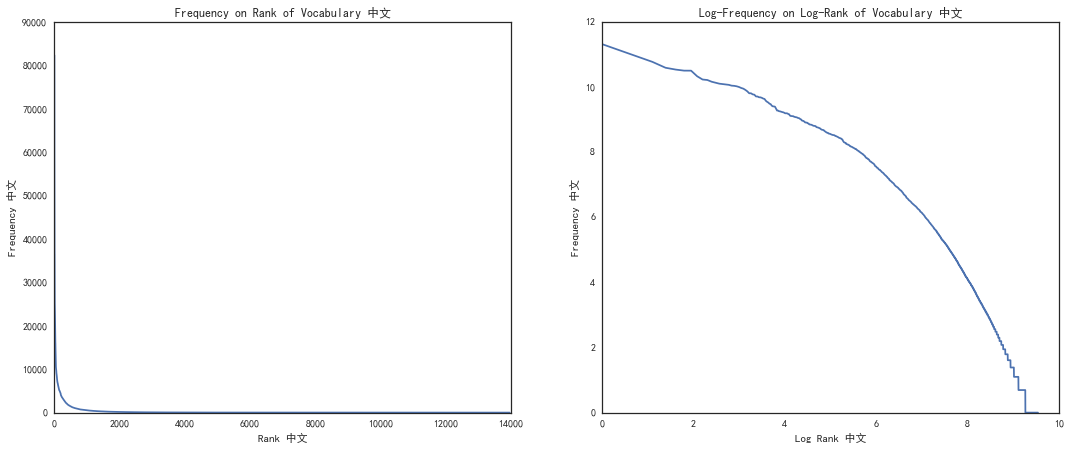

_Figure 1: Frequency-Rank Graphs of Our Vocabulary._ 中文

,Word,Frequency
0,credit,82342
1,account,58454
2,would,47840
3,loan,39920
4,bank,37751
5,told,36548
6,payment,36509
7,received,30722
8,debt,27829
9,mortgage,27401


_Table 1: The $15$ most frequent words with their frequencies_ 中文

,Word,Frequency
13947,metropolitan,1
13948,relenting,1
13949,curtly,1
13950,metaphorically,1
13951,monogram,1
13952,memorable,1
13953,monolithic,1
13954,proximately,1
13955,almighty,1
13956,furtive,1


_Table 2: The $15$ least frequent words with their frequencies_ 中文

In [57]:
wordFrequencyFrame = pd.DataFrame(c.most_common(len(c)),columns = ["Word","Frequency"])
#plot frequency on rank
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
#freq-rank
ax1.plot(wordFrequencyFrame.index,wordFrequencyFrame["Frequency"])
ax1.set_title("Frequency on Rank of Vocabulary 中文")
ax1.set_xlabel("Rank 中文")
ax1.set_ylabel("Frequency 中文")
#freq-logRank
ax2.plot(np.log(wordFrequencyFrame.index + 1),np.log(wordFrequencyFrame["Frequency"]))
ax2.set_title("Log-Frequency on Log-Rank of Vocabulary 中文")
ax2.set_xlabel("Log Rank 中文")
ax2.set_ylabel("Frequency 中文")
plt.show()
printmd("_Figure 1: Frequency-Rank Graphs of Our Vocabulary._ 中文")
#get 15 most common
top15FrequencyFrame = wordFrequencyFrame.iloc[0:15,:]
display(top15FrequencyFrame)
printmd("_Table 1: The $15$ most frequent words with their frequencies_ 中文")
#get 15 least common
bottom15FrequencyFrame = wordFrequencyFrame.iloc[(wordFrequencyFrame.shape[0]-15):wordFrequencyFrame.shape[0],:]
display(bottom15FrequencyFrame)
printmd("_Table 2: The $15$ least frequent words with their frequencies_ 中文")

We see by the log-frequency on log-rank graph (Figure 1, right) that fitting a [Zipf Distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) to this graph may potentially over-prediction the probability of less frequent words occuring, which suggests that our vocabulary is much more right-skewed than in a more ideal vocabulary. We see that the 15 most common words portray words that are very financially relevant, such as credit, account, loan, and bank.

Let us now view the token-type graph to study richness of the vocabulary in the corpus.

In [58]:
#get token-type list
typeSet = set([]) #we will add to this over time
typeTokenList = [] #we will add tuples to this
for i in range(len(k)):
    givenToken = k[i]
    if (givenToken not in typeSet): #we should get a new type count
        typeSet.add(givenToken)
    #then add information to type-token list
    typeTokenList.append((i+1,len(typeSet)))

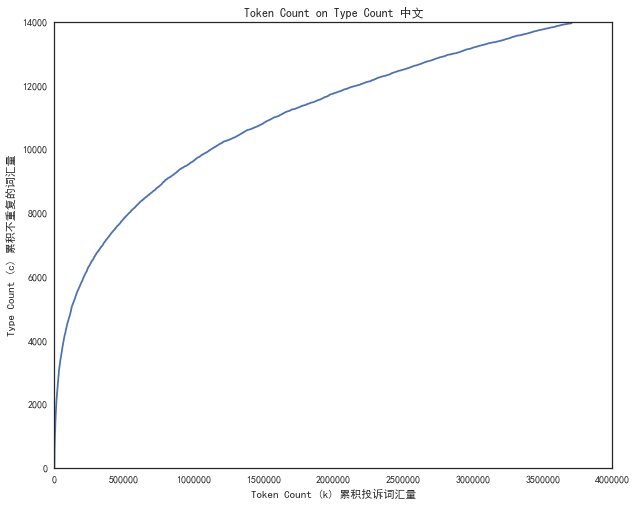

_Figure 2: Type-Token Graph for full vocabulary._ 中文

In [59]:
#then plot
typeTokenFrame = pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])
plt.figure(figsize=(10,8))
plt.plot(typeTokenFrame["Token Count"],typeTokenFrame["Type Count"])
plt.xlabel("Token Count (k) 累积投诉词汇量")
plt.ylabel("Type Count (c) 累积不重复的词汇量")
plt.title("Token Count on Type Count 中文")
plt.show()
printmd("_Figure 2: Type-Token Graph for full vocabulary._ 中文")

We see that the growth of our vocabulary begins to slow after around $1000000$ tokens in our corpus, which is about $27\%$ of the way through our corpus. To me, this suggests that the vocabulary is not extremely diverse, although it is difficult to compare without studying the relationship with other corpora.

It would be very interesting to see if the richness of vocabulary changes based on the product being addressed. Let us take a look at the distribution of products over observations with complaint narratives and the type-token graphs for each product.

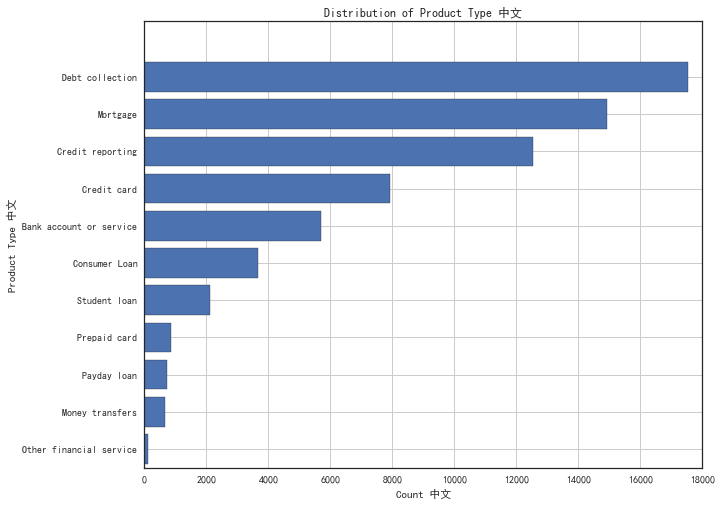

_Figure 3: Distribution of product types. 中文_

The number of narratives of the product type 'Other financial service' is $110$.

In [60]:
productCountFrame = complaintNarrativeFrame.groupby("product")["consumer_complaint_narrative"].count()
productCountFrame = productCountFrame.sort_values()
#from pylab import *
#val = 3+10*rand(5)    # the bar lengths
pos = np.arange(productCountFrame.shape[0])+.5    # the bar centers on the y axis

plt.figure(figsize=(10,8))
plt.barh(pos,productCountFrame, align='center')
plt.yticks(pos,productCountFrame.index)
plt.xlabel('Count 中文')
plt.ylabel("Product Type 中文")
plt.title('Distribution of Product Type 中文')
plt.grid(True)
plt.show()
printmd("_Figure 3: Distribution of product types. 中文_")
printmd("The number of narratives of the product type 'Other financial service' is $" + str(
        productCountFrame["Other financial service"]) + "$.")

We see that our distribution seems very uneven, as we have a large amount of Mortgage, Debt Collection, and credit reporting narratives, but relatively few observations in money transfer, other financial services, and payday loans. This may suggest that it would be difficult to predict some of these smaller groups if we are interested in a predictive model on this issue.

In [61]:
#declare functions before making type-token procedures
def makeTypeTokenFrame(tokenList):
    #helper that makes our type-token frame for a given token list
    typeSet = set([]) #we will add to this over time
    typeTokenList = [] #we will add tuples to this
    for i in range(len(tokenList)):
        givenToken = tokenList[i]
        if (givenToken not in typeSet): #we should get a new type count
            typeSet.add(givenToken)
        #then add information to type-token list
        typeTokenList.append((i+1,len(typeSet)))
    return pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])

def makeTokenList(consumerComplaintFrame):
    #helper that makes token list from the given complaint frame
# Python3
    s = StringIO()
# Python2
#     s = BytesIO()
    
    consumerComplaintFrame["consumer_complaint_narrative"].apply(lambda x: s.write(x))
    k = s.getvalue() #gets string of unprocessed words
    s.close()
    #get actual unprocessed words
    #k = k.lower()
    k = k.split()
    k = [i for i in k if i in words and i not in stopWords] #only consider legal words
    return k

def getTokenTypeFrameForProduct(consumerComplaintFrame,productName):
    #helper that gets our token-type frame for narratives of a given product name
    #get observations with this product name
    givenProductComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["product"] == productName]
    #then get token list
    tokenList = makeTokenList(givenProductComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [62]:
#run through our observations
typeTokenFrameDict = {} #we will adds to this
for productName in productCountFrame.index:
    typeTokenFrameDict[productName] = getTokenTypeFrameForProduct(complaintNarrativeFrame,productName)

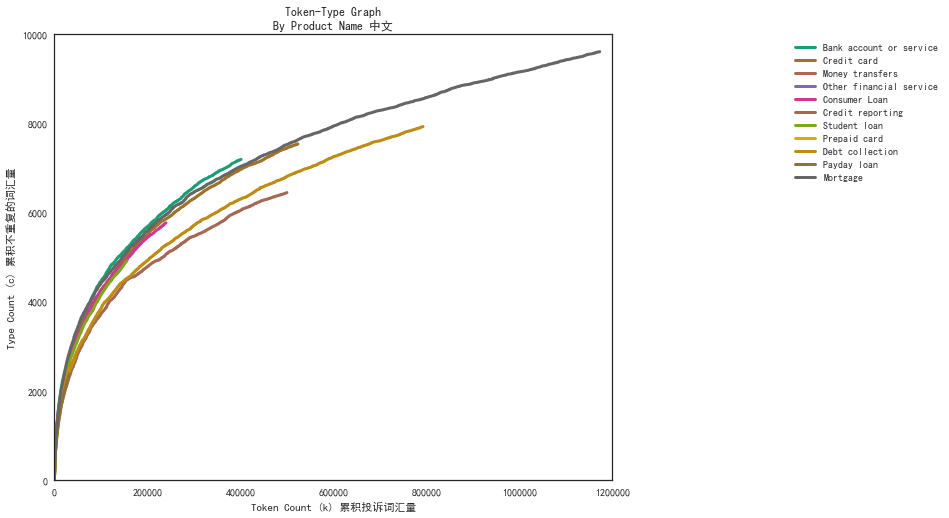

_Figure 4: Token-Type Graph By Product Name._ 中文

In [63]:
cmap = plt.get_cmap('Dark2')
colorList = [cmap(i) for i in np.linspace(0, 1, len(typeTokenFrameDict))]
plt.figure(figsize=(10,8))
for i in range(len(typeTokenFrameDict)):
    productName = list(typeTokenFrameDict)[i]
    givenProductTokenTypeFrame = typeTokenFrameDict[productName]
    plt.plot(givenProductTokenTypeFrame["Token Count"],
             givenProductTokenTypeFrame["Type Count"], linewidth=3, label = productName,
            c = colorList[i])
plt.legend(bbox_to_anchor = (1.6,1))
plt.xlabel("Token Count (k) 累积投诉词汇量")
plt.ylabel("Type Count (c) 累积不重复的词汇量")
plt.title("Token-Type Graph\nBy Product Name 中文")
plt.show()
printmd("_Figure 4: Token-Type Graph By Product Name._ 中文")

This graph makes one obvious thing apparent: that there are many more mortgage complaint observations than other categories. While it is difficult to define which of these products have the richest vocabulary due to the difference in line lengths, it is very obvious that debt collection and credit reporting seem to have less rich vocabularies than the other products. This may be essential for distinguishing the groups, although it is currently difficult to tell why this is. I am open to discussion on possible hypotheses for this.

What may also be useful is to consider if we could predict whether a customer would eventually dispute the final resolution of a claim based on the language in the complaint itself. While it is likely this will also be a function of the company's decision of the company's response to the consumer, it may be interesting to study if vagueness or complexity of a dispute would factor into whether a consumer disputes a resolution.

In [64]:
def getTokenTypeFrameForDispute(consumerComplaintFrame,disputeLev):
    #helper that gets our token-type frame for narratives of a dispute level
    #get observations with this product name
    givenDisputeComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["consumer_disputed"] == disputeLev]
    #then get token list
    tokenList = makeTokenList(givenDisputeComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [65]:
consumerDisputeDict = {} #we will add to this
for disputeLev in complaintNarrativeFrame["consumer_disputed"].unique():
    consumerDisputeDict[disputeLev] = getTokenTypeFrameForDispute(complaintNarrativeFrame,disputeLev)

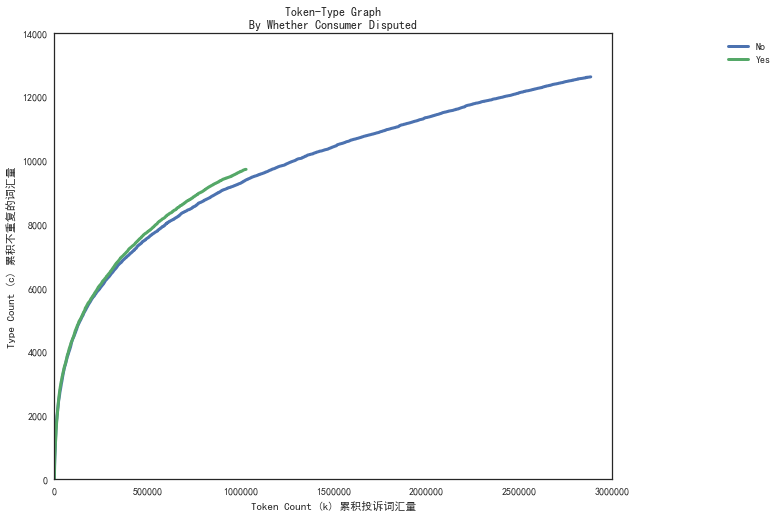

_Figure 5: Token-Type Graph By whether the consumer disputed._ 中文

In [66]:
plt.figure(figsize=(10,8))
for disputeLev in consumerDisputeDict:
    DisputeTokenTypeFrame = consumerDisputeDict[disputeLev]
    plt.plot(DisputeTokenTypeFrame["Token Count"],
             DisputeTokenTypeFrame["Type Count"], linewidth=3, label = disputeLev)
plt.legend(bbox_to_anchor = (1.3,1))
plt.xlabel("Token Count (k) 累积投诉词汇量")
plt.ylabel("Type Count (c) 累积不重复的词汇量")
plt.title("Token-Type Graph\nBy Whether Consumer Disputed")
plt.show()
printmd("_Figure 5: Token-Type Graph By whether the consumer disputed._ 中文")

While it looks as though the "Yes" observations have a slightly richer vocabulary than the "No" observations, seems to be a relatively small difference.

Nonetheless, I think this would be one of the interesting prediction problems to see whether or not the language of a given consumer complaint is as much of a reason for a dispute as the company response.

## Predicting Consumer Disputes

We will initially model our language using bag-of-words with TF-IDF encodings. This is for the sake of simplicity: if there may be another possible language model that may better represent the language-generation process for prediction sake, I may re-model the language.

# By: www.KudosData.com from 2016-11-22

## 计算TF-iDF数值赋予相对应的词组

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = complaintNarrativeFrame["consumer_complaint_narrative"]

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df[['词数表']]

## 把TF-iDF数值赋予相对应的词组

In [68]:
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [69]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 66806 rows/docs X 54080 columns/words ]
It contains 3612868480 eliments: one score per word per document !


In [70]:
# Add tfidf score into dataframe
complaintNarrativeFrame['tfidf'] = tfidftables

In [71]:
complaintNarrativeFrame[['company', 'consumer_complaint_narrative', 'consumer_disputed', 'tfidf']].head()

,company,consumer_complaint_narrative,consumer_disputed,tfidf
0,"Diversified Consultants, Inc.",XXXX has claimed I owe them {$27.00} for XXXX ...,No,"{'of': 0.0435071415016, 'how': 0.103494059457,..."
1,M&T Bank Corporation,Due to inconsistencies in the amount owed that...,No,"{'monies': 0.0855892550095, 'remaining': 0.076..."
2,Wells Fargo & Company,In XX/XX/XXXX my wages that I earned at my job...,Yes,"{'out': 0.030556594543, 'almost': 0.0269998294..."
3,JPMorgan Chase & Co.,I have an open and current mortgage with Chase...,Yes,"{'an': 0.0468742210736, 'mortgage': 0.13005811..."
4,Rushmore Loan Management Services LLC,XXXX was submitted XX/XX/XXXX. At the time I s...,Yes,"{'are': 0.027160474505, 'discrimination': 0.08..."


In [72]:
complaintNarrativeFrame['consumer_disputed_TF'] = complaintNarrativeFrame['consumer_disputed'] == 'Yes'

0.766832320450259


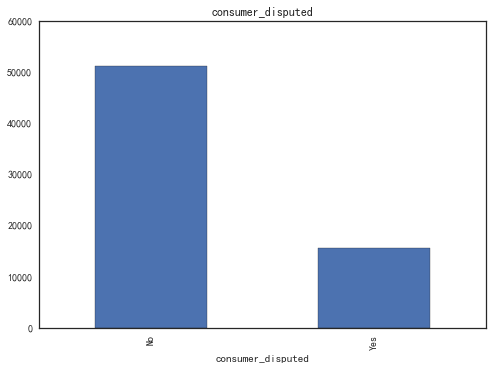

In [73]:
print (len(complaintNarrativeFrame[complaintNarrativeFrame['consumer_disputed'] == 'No'])/len(complaintNarrativeFrame))
complaintNarrativeFrame.groupby('consumer_disputed').size().plot(kind='bar',title='consumer_disputed')


## 老样子，还有一些数据预处理工作

In [74]:
# 划分训练和测试数据集 80% v.s. 20%
np.random.seed(88)
msk = np.random.rand(len(complaintNarrativeFrame)) < 0.8

# 训练数据集 train_data
train_data = complaintNarrativeFrame[msk]
# 测试数据集 test_data
test_data = complaintNarrativeFrame[~msk]

print ('训练数据数量 : %d' %len(train_data))
print ('测试数据数量 : %d' %len(test_data))

训练数据数量 : 53469
测试数据数量 : 13337


In [75]:
# 设定 训练数据集 目标值
train_data_y = train_data['consumer_disputed_TF']

# 设定 训练数据集 特征值 （ Dict 数据结构）
train_data_x = train_data['tfidf']

In [139]:
# 设定 测试数据集 目标值 （此为实际值）
test_data_y = test_data['consumer_disputed_TF']

# 设定 测试数据集 特征值 （ Dict 数据结构）
test_data_x = test_data['tfidf']

In [140]:
# test for Citibank only

# test_data_y = test_data['consumer_disputed_TF'][test_data['company'] == 'Citibank']
# test_data_x = test_data['tfidf'][test_data['company'] == 'Citibank']
# print('No. of test cases for Citibank: %d' % len(test_data_y))

### 下一步，数据结构变换：把 Dict 转换为 稀疏矩阵， 用于机器学习模型的输入。
### 但是，为什么要做数据转换？ 原因是不同的数据模型/机器学习算法的原理和数学计算优化过程不同，所以对输入的特征值会有各种花样百出的要求…… 但别担心，我们循序渐进地一起学习。

In [141]:
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
vec = DictVectorizer()
train_data_xm = vec.fit_transform(train_data_x) # 把 Dict 转换为 稀疏矩阵，用于算法的输入

## 摩拳擦掌，要正式开始训练分类数据模型了

In [142]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV  # 逻辑回归分类模型
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm  # Support Vector Machine 模型

sentiment_model = LogisticRegression()
# sentiment_model = LogisticRegressionCV()
# sentiment_model = svm.SVC(kernel = 'rbf')
# sentiment_model = RandomForestClassifier(random_state=0)
# sentiment_model = KNeighborsClassifier(n_neighbors=3)


sentiment_model.fit(train_data_xm, train_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 数据模型训练完成！
### 现在用测试数据来验证：

In [143]:
test_data_xm = vec.transform(test_data_x) # 数据结构变换：把 Dict 转换为 稀疏矩阵， 用于逻辑回归分类模型的输入
test_data_pr = sentiment_model.predict(test_data_xm) # 测试数据集评论的评分（预测值）


# 评测分类模型的性能

# 性能考量1
### 我们来考察 混淆矩阵（它是分类问题中重要的模型性能测评工具）

又名：列联表，误差矩阵 （confusion matrix） 是一种验证模型性能的可视化工具。矩阵的每一列代表一个类的实例预测，而每一行表示一个实际的类的实例。基于实际的名称可以更容易判断机器是否将两个不同的类混淆了。

<img style="float: left;" width="100%" src="ref\confusion_matrix.jpg">

   混淆矩阵 
[[10150   147]
 [ 2867   173]]


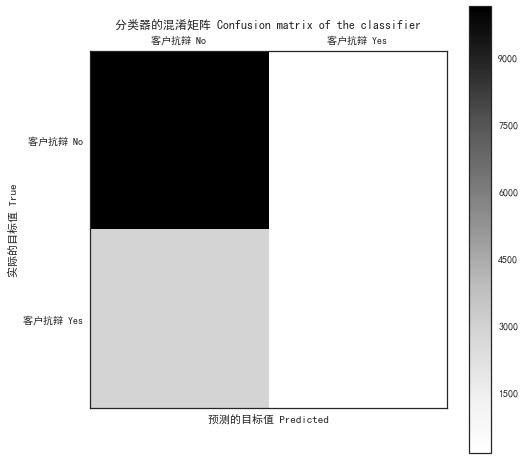

In [144]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 混淆矩阵 计算
labels = [u'客户抗辩 No', u'客户抗辩 Yes']
cm = confusion_matrix(array(test_data_y), test_data_pr)
print('   混淆矩阵 ')
print(cm)

# 混淆矩阵 可视化 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title(u'分类器的混淆矩阵 Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel(u'预测的目标值 Predicted')
plt.ylabel(u'实际的目标值 True')
plt.show()

# 性能考量2
### 模型精度测量： 精度 = （正确的抗辩预测 + 正确的不抗辩预测 ） / 所有测试的投诉数目

最低 0% 最高 100%

In [145]:
model_accuracy = sentiment_model.score(test_data_xm, test_data_y)
print ('模型预测精度 : %.2f %%' % (model_accuracy * 100))

模型预测精度 : 77.40 %


### 除了精度测量，在很多情况下，我们是不是还想知道模型对她自己给出的褒贬结果有多少信心？有多“靠谱”？
### 所以一般的分类模型还能给出对于每个预测结果的“信心度”，以预测模型给出的 每篇评论的消极分类可能性 和 积极分类可能性 来度量。（背后其实是基于数据统计和概率的度量）

In [146]:
print ('      [客户抗辩可能性No: 客户抗辩可能性Yes:]')
sentiment_model.predict_proba(test_data_xm)

      [客户抗辩可能性No: 客户抗辩可能性Yes:]


array([[ 0.53257744,  0.46742256],
       [ 0.76598243,  0.23401757],
       [ 0.74186243,  0.25813757],
       ..., 
       [ 0.74617653,  0.25382347],
       [ 0.82917907,  0.17082093],
       [ 0.87036855,  0.12963145]])

In [147]:
# 获取 积极分类可能性
predict_proba_positive = [i[1] for i in sentiment_model.predict_proba(test_data_xm)]

# 获取 Log(积极分类可能性) 使用Log()变换，人为减小 可能性/概率输出 的差异
predict_log_proba_positive = [i[1] for i in sentiment_model.predict_log_proba(test_data_xm)]

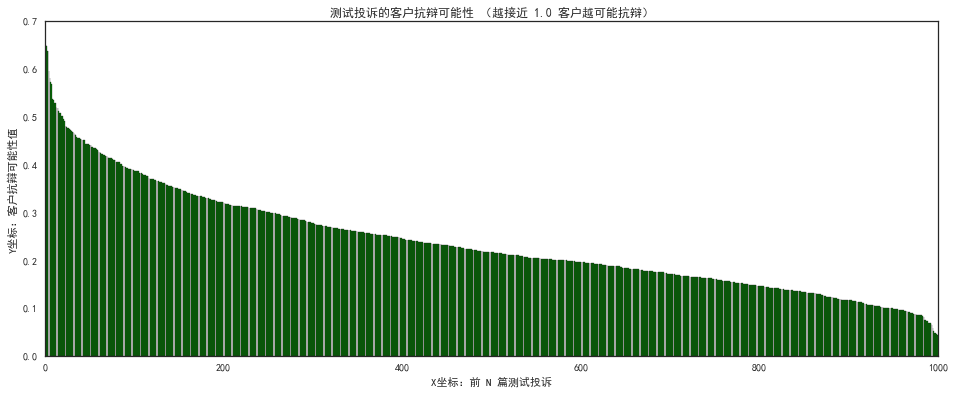

In [148]:
# 图表显示
plt.figure(figsize=(16,6))
plt.title(u'测试投诉的客户抗辩可能性 （越接近 1.0 客户越可能抗辩）')  
plt.xlabel(u'X坐标：前 N 篇测试投诉')  
plt.ylabel(u'Y坐标：客户抗辩可能性值') 
#plt.yscale('log')
plt.bar(range(0, len(predict_proba_positive[0:1000])), sorted(predict_proba_positive[0:1000], reverse=True), color='green')
plt.show()

# 性能考量3
### 感受性曲线 ROC Curve
### 图线表征的是，在特定的 伪阳性 (FP, false positive) 可能性时，预测真阳性 (TP, true positive) 的准确率

ROC感受性曲线下面积（英语：Area under the Curve of ROC (AUC ROC)）。简单来说：AUC值越大的分类器，正确率越高。从AUC判断分类器（预测模型）优劣的标准：

* AUC = 1，是完美分类器，采用这个预测模型时，存在至少一个阈值能得出完美预测。绝大多数预测的场合，不存在完美分类器。

* 0.5 < AUC < 1，优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。

* AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。

* AUC < 0.5，比随机猜测还差；但只要总是反预测而行，就优于随机猜测。


In [149]:
# 先计算 ROC 曲线的数据点，会用于下一步图形显示
# Compute ROC curve and AUC area for each class

# 伪阳性 
fpr = dict()

# 真阳性
tpr = dict()

# ROC 曲线下方的面积
roc_auc = dict()

# 二分分类（褒 和 贬）
n_classes = 2 

# 循环计算 伪阳性 真阳性 用于图形显示
for i in range(1, n_classes):
    fpr[i], tpr[i], _ = roc_curve(array(test_data_y), predict_proba_positive)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算 ROC 曲线下方的面积
# Compute micro-average ROC curve and AUC-ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(array(test_data_y), predict_proba_positive)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#tpr['micro']
#tpr[1]

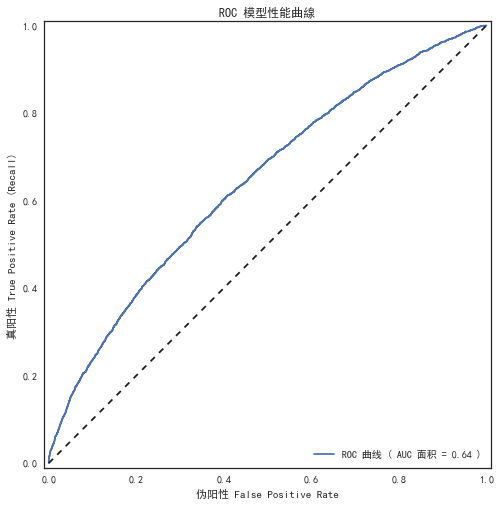

In [150]:
# 显示 ROC 曲线
# Plot of a ROC curve for a specific class
plt.figure(figsize=(8, 8))
plt.plot(fpr[1], tpr[1], label=u'ROC 曲线 ( AUC 面积 = %0.2f )' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel(u'伪阳性 False Positive Rate')
plt.ylabel(u'真阳性 True Positive Rate (Recall)')
plt.title(u'ROC 模型性能曲線')
#plt.legend(loc='best')
plt.legend(loc='lower right')
plt.show()


# 太好了，您已经掌握很多高深的模型性能测量技能了！
# 接下来让我们用训练好的模型，回过头来考察花旗银行的投诉

In [151]:
Citi_complaints = complaintNarrativeFrame[['company', 'consumer_complaint_narrative', 'consumer_disputed', 'tfidf']]
Citi_complaints = Citi_complaints[complaintNarrativeFrame['company'] == 'Citibank']

In [152]:
Citi_complaints['predicted_consumer_disputed'] = [i[1] for i in sentiment_model.predict_proba
                                          (vec.transform(Citi_complaints['tfidf']))]

In [153]:
Citi_complaints = Citi_complaints.sort_values('predicted_consumer_disputed', ascending=False)

In [154]:
len(Citi_complaints)

2789

In [155]:
# print(Citi_complaints.iloc[1, Citi_complaints.columns.get_loc('tfidf')])

In [156]:
Citi_complaints.head(10)

,company,consumer_complaint_narrative,consumer_disputed,tfidf,predicted_consumer_disputed
21114,Citibank,"I filed a complaint "" Qualified Written Reques...",No,"{'holding': 0.190687383285, 'on': 0.0475641278...",0.695056
36391,Citibank,RE : Citi retaliatory closing of accts in good...,Yes,"{'harm': 0.0283232019893, 'dispute': 0.0924811...",0.674052
17898,Citibank,We made a purchase at Home Depot during XXXX. ...,No,"{'contact': 0.0178474819818, 'almost': 0.02463...",0.662732
57595,Citibank,CitiCards is not Protecting Consumers from Fra...,Yes,"{'dispute': 0.0315994573218, 'history': 0.0393...",0.654503
13257,Citibank,I cosigned a loan for my daughter who lives XX...,Yes,"{'are': 0.024254200766, 'out': 0.0295490263305...",0.611914
40057,Citibank,i received a letter from citibank dated XX/XX/...,Yes,"{'are': 0.0458827096375, 'out': 0.027949578884...",0.602953
38138,Citibank,There is an item on my Credit Bureau reports t...,Yes,"{'out': 0.0370490952646, 'credits': 0.09370376...",0.601917
23106,Citibank,I ordered flowers and other gifts to be delive...,Yes,"{'contact': 0.0474061252065, 'dispute': 0.2072...",0.584619
45301,Citibank,I have a consumer Credit Card called Home Depo...,Yes,"{'fraudulent': 0.0472741063929, 'out': 0.02866...",0.573514
48176,Citibank,I notified Citibank of a dispute with Home Dep...,Yes,"{'me': 0.0294055361017, 'dispute': 0.067152609...",0.570253


In [157]:
Citi_complaints.tail(10)

,company,consumer_complaint_narrative,consumer_disputed,tfidf,predicted_consumer_disputed
38953,Citibank,I have had a {$2.00} outstanding balance on my...,No,"{'contact': 0.0700751791176, 'on': 0.090449606...",0.060907
1483,Citibank,I have received several phone calls about a de...,No,"{'contact': 0.112823766752, 'on': 0.0242712312...",0.058684
56298,Citibank,The Macy 's online credit card access was unav...,No,"{'out': 0.0370250891269, '20': 0.077008891204,...",0.057529
473,Citibank,Macys credit card system application takes the...,No,"{'out': 0.0595248735693, 'card': 0.06704259216...",0.057475
41287,Citibank,I went to make a payment online and their webs...,No,"{'payment': 0.194436551916, 'them': 0.07956260...",0.056435
21947,Citibank,I 'm receiving 3+ phone calls a day from this ...,No,"{'someone': 0.299187595373, 'number': 0.233137...",0.056261
8308,Citibank,I have had a Macys credit card for several yea...,No,"{'contact': 0.0697664167162, 'charging': 0.104...",0.050612
54872,Citibank,Received instant credit from Macy 's in-store ...,No,"{'before': 0.0730475888639, 'me': 0.0340916697...",0.049233
57244,Citibank,Harassing phone calls. I have never missed a p...,No,"{'before': 0.0818072139569, 'off': 0.074554097...",0.046927
38658,Citibank,I refinanced my previous loan with One Main Fi...,No,"{'employer': 0.08457053102, 'out': 0.039034937...",0.043908


## 现在仔细看看一些评论：

In [158]:
print(Citi_complaints.iloc[0, Citi_complaints.columns.get_loc('consumer_complaint_narrative')])

I filed a complaint " Qualified Written Request '' on XXXX/XXXX/2015 and received no response what so ever. Not even an acknowledgement of receipt from Citi Mortgage in reference to my escrow account and the illegal holding of my mortgage payment As per fax receipts all papers where received at the number given to me by Citi XXXX. supervisor. 
Please see attached documents for entire explanation. 



In [159]:
print(Citi_complaints.iloc[1, Citi_complaints.columns.get_loc('consumer_complaint_narrative')])

RE : Citi retaliatory closing of accts in good standing immediately after I blow the whistle on Citi 's suspicious fraudulent business practices. 

CITI : Your response " As explained in our XXXX XXXX, 2015 letter, we maintain our right to close your accts at any time for any reason. " XXXX : Your understanding of fed and state law is patently incorrect. No bank, including Citi, may close an acct for any reason if that reason is tantamount to discrimination or retaliation against a consumer for exercising his/her right to dispute a charge or complain of a bank 's fraudulent business practices, such as Citi discriminated and retaliated against me in the instant case. Citi asserts its mistaken assumption of absolute unqualified privilege in a federally regulated financial industry. 

Citi confirmed my accts were in excellent standing for yrs. Only after I complained about my suspicion of Citi 's fraud and lack of due process and due diligence re : my disputes did Citi close my acct w/o N

In [160]:
print(Citi_complaints.iloc[-1, Citi_complaints.columns.get_loc('consumer_complaint_narrative')])

I refinanced my previous loan with One Main Financial back in XXXX & I lost my job at the end of XXXX. I had been at my job for almost 5yrs. I had a payment due in XXXX & I immediately start receiving calls & I stated my situation but the calls persisted. While trying to obtain other employment, I was open & honest about my findings nut the calls got more frequently. I 've talked to several employees there but they started to get very unprofessional with their tone of voice, tactics & eventually threatened to sue plus continue to call. I 've gotten XXXX calls in XXXX day leaving messages & getting calls from different numbers at all times of the day & well into the late night harassing me. I answered strange numbers thinking it was an employer contacting me about a job & it turns out being them. I had just received a call from an unfamiliar number & it was them calling me stating I was n't being financially responsible, insisting on me selling my household items to pay them by tomorrow

In [161]:
print(Citi_complaints.iloc[-2, Citi_complaints.columns.get_loc('consumer_complaint_narrative')])

Harassing phone calls. I have never missed a payment but recently had XXXX surgery which requires months of recovery. I called them to explain my situation and since then I received phone calls constantly on my cell phone everyday. When asked to please stop calling, they said we ca n't because you 're on an automated call system. It took talking to XXXX reps. before XXXX of them agreed to take my number off. 
Since then they call my home phone at least XXXX times a day until I answer. This has become harassment now. I am at home trying to recover from my surgery and they just wo n't stop calling. 



# 结束语： 
# 恭喜您！您已经掌握分类机器学习和自然语言处理的一些高级数据科学技术了！